Check data

In [3]:
import pandas
import matplotlib.pyplot as plt


In [2]:
from google.colab import files
uploaded = files.upload()

Saving airline-passengers.csv to airline-passengers.csv


Import libraries

In [4]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [5]:
# fix random seed for reproducibility
dataset = pandas.read_csv('airline-passengers.csv', engine='python')

numpy.random.seed(7)
dataset.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Use only passenger count field from the data.<br/>
Extract the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.

In [6]:
# load the dataset
dataframe = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:] 

Below function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1. <br/>

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

Let’s use this function to prepare the train and test datasets for modeling.

In [9]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: **[samples, time steps, features]**.

Currently, our data is in the form:**[samples, features]** and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using **numpy.reshape()** as follows:

In [10]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [11]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 2s - loss: 0.0418 - 2s/epoch - 18ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0195 - 129ms/epoch - 1ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0147 - 130ms/epoch - 1ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0135 - 135ms/epoch - 1ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0126 - 134ms/epoch - 1ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0117 - 138ms/epoch - 1ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0107 - 131ms/epoch - 1ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0097 - 131ms/epoch - 1ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0088 - 135ms/epoch - 1ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0079 - 134ms/epoch - 1ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0070 - 140ms/epoch - 1ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0062 - 136ms/epoch - 1ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0054 - 141ms/epoch - 1ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0047 - 125ms/epoch - 1ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0042 - 130ms/epoch - 1ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0036 - 135ms/epoc

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models. <br/>

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 23.11 RMSE
Test Score: 50.69 RMSE


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model. <br/>

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

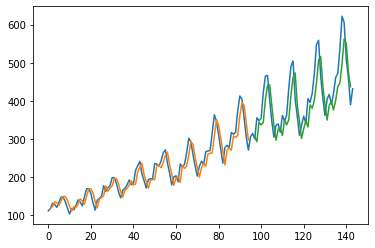

In [13]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()